## Helping new Uber drivers make more money  <br>
<br>
![title](uber_driver.jpg)
<br>
New drivers might have trouble earning money when they join because they don’t know when and where to drive
to maximize their earnings. If drivers drove in better locations and times, Uber and driver partners would earn more money, and riders would get shorter ETA’s and lower prices. 
<br>
<br>
Lets build a model to predict the benefit of driving at different times and locations in the coming week, and create a tool to  give a recommendation about
when and where to drive.

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [109]:
df = pd.read_csv('/Users/aaronmichaelbroderick/Desktop/Data_Science/Data/Uber_driver_trips.csv')
print(df.shape)

(59854, 9)


In [110]:
df.head(1)

,trip_id,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo
0,b3cb-b9bf,4649-2f0a,completed,3.52,4/9/12 6:12,1.0,4.24,Allen Abby,Chelsea Court


In [111]:
df.start_geo.value_counts()

Chelsea Court    40288
Allen Abby       10459
Daisy Drive       4751
Blair Bend        4356
Name: start_geo, dtype: int64

## Generate some time features

In [112]:
import datetime
df.request_time = df.request_time.apply(pd.to_datetime)

In [113]:
df.head(1)

,trip_id,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo
0,b3cb-b9bf,4649-2f0a,completed,3.52,2012-04-09 06:12:00,1.0,4.24,Allen Abby,Chelsea Court


In [114]:
days = []
for i in range(len(df)):
    days.append(df.request_time[i].weekday())
    
# 0 = Monday, 6 = Sunday

df['days'] = days

In [115]:
hours = []
for i in range(len(df)):
    hours.append(df.request_time[i].hour)

# Military Time

df['hours'] = hours

In [116]:
# Days since first date in dataset

lag = []

for i in range(len(df)):
    lag_days = (df.request_time[i] - df.request_time.min()).days
    lag.append(lag_days)

df['lag'] = lag

In [117]:
## Make new variables.  The average surge multiplier for 1,2,7,14 days ago for that 
## hour, day and starting location

lag_minus_7 = []
lag_minus_14 = []
lag_minus_1 = []
lag_minus_2 = []

for i in range(len(df)):
    local_lag = df.lag[i]
    day = df.days[i]
    hour = df.hours[i]
    start_loc = df.start_geo[i]

    if local_lag - 7 >= 0:
        local_lag_minus_7 = df.lag[i] - 7
        lag_minus_7.append(df[(df['hours'] == df.hours[i]) & (df['lag'] == local_lag_minus_7) & (df['start_geo'] == df.start_geo[i])].surge_multiplier.mean())
    else:
        lag_minus_7.append(99)
        
    if local_lag - 14 >= 0:
        local_lag_minus_14 = df.lag[i] - 14
        lag_minus_14.append(df[(df['hours'] == df.hours[i]) & (df['lag'] == local_lag_minus_14) & (df['start_geo'] == df.start_geo[i])].surge_multiplier.mean())
    else:
        lag_minus_14.append(99)
        
    if local_lag - 1 >= 0:
        local_lag_minus_1 = df.lag[i] - 1
        lag_minus_1.append(df[(df['hours'] == df.hours[i]) & (df['lag'] == local_lag_minus_1) & (df['start_geo'] == df.start_geo[i])].surge_multiplier.mean())
    else:
        lag_minus_1.append(99)

    if local_lag - 2 >= 0:
        local_lag_minus_2 = df.lag[i] - 2
        lag_minus_2.append(df[(df['hours'] == df.hours[i]) & (df['lag'] == local_lag_minus_2) & (df['start_geo'] == df.start_geo[i])].surge_multiplier.mean())
    else:
        lag_minus_2.append(99)
    
    if i % 5000 == 0:
        print (i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [118]:
df['surge_ave_minus_7'] = lag_minus_7
df['surge_ave_minus_14'] = lag_minus_14
df['surge_ave_minus_1'] = lag_minus_1
df['surge_ave_minus_2'] = lag_minus_2

In [119]:
df = df[(df['surge_ave_minus_7'] != 99) & (df['surge_ave_minus_14'] != 99) & (df['surge_ave_minus_1'] != 99) & (df['surge_ave_minus_2'])]
df = df.reset_index(drop = True)
df = df.fillna(1)

In [120]:
df.head(1)

,trip_id,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo,days,hours,lag,surge_ave_minus_7,surge_ave_minus_14,surge_ave_minus_1,surge_ave_minus_2
0,8569-0fbf,4003-e2e7,completed,2.63,2012-05-06 05:44:00,2.0,8.24,Blair Bend,Chelsea Court,6,5,27,1.125,1.633333,1.3,1.15


In [121]:
df.shape

(30438, 16)

## What is the benefit of driving during high surge times?
<br>

<font size = 4> The surge_multiplier shows how much the price of the fare increases during times where demand is greater than supply.  Is there a financial benefit to the driver for taking these fares? </font>

In [122]:
surge_amounts = list(df.surge_multiplier.value_counts().index)
surge_amounts = surge_amounts[:15]

In [123]:
average_payout = []
surge_amount = []

for i in range(len(surge_amounts)):
    data = df[df['surge_multiplier'] == surge_amounts[i]]
    surge_amount.append(surge_amounts[i])
    average_payout.append(data['driver payout'].mean())

[Text(0,0.5,'Average Fare $'), Text(0.5,0,'Surge Multiplier')]

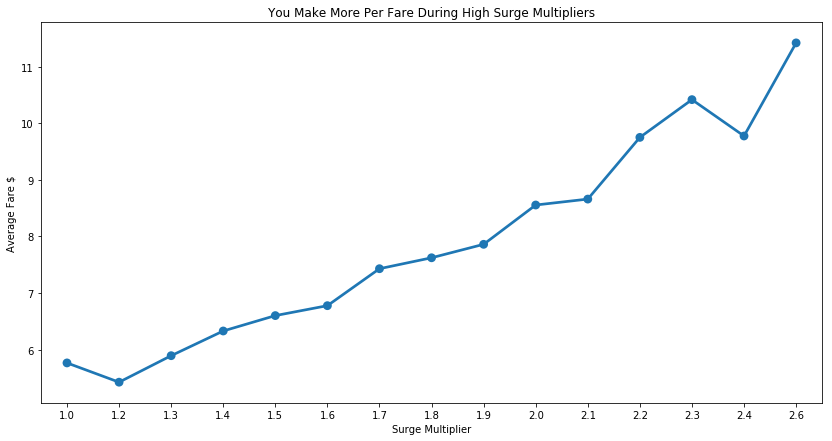

In [124]:
plt.figure(figsize=(14,7))
ax = sns.pointplot(surge_amount, average_payout)
ax.set_title('You Make More Per Fare During High Surge Multipliers')
ax.set(xlabel='Surge Multiplier', ylabel='Average Fare $')

In [125]:
## From the chart above, there is a clear linear relationship from SM 1.3 to 2.3.

money = pd.DataFrame()

money['surge_multiplier'] = surge_amount
money['average_payout'] = average_payout
money = money[(money['surge_multiplier'] >= 1.3) & (money['surge_multiplier'] <= 2.3)]

# Find the change between surge multipliers

change = [0]
for i in range(3,13):
    x = money.average_payout[i] - money.average_payout[i-1]
    change.append(x)
    
money['change'] = change
money = money[money['surge_multiplier'] > 1.3]

surge_increase_value = str(money.change.mean())[:4]
print()
print( 'For every 0.1 increase in surge multiplier, you make about ' + str(surge_increase_value)[:4] + ' cents more per fare.')


For every 0.1 increase in surge multiplier, you make about 0.45 cents more per fare.


## Lets make a model to predict surge values in the coming week.  
<br>
<font size = 4>If we can accurately predict the surge value for the upcoming week, we can build a recommender function for new drivers to tell them when and where they can make the most money. </font>

In [126]:
df.head(1)

,trip_id,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo,days,hours,lag,surge_ave_minus_7,surge_ave_minus_14,surge_ave_minus_1,surge_ave_minus_2
0,8569-0fbf,4003-e2e7,completed,2.63,2012-05-06 05:44:00,2.0,8.24,Blair Bend,Chelsea Court,6,5,27,1.125,1.633333,1.3,1.15


In [127]:
reg_df = df
reg_df = reg_df[['surge_multiplier','start_geo','end_geo','days','hours','surge_ave_minus_7','surge_ave_minus_14','surge_ave_minus_1','surge_ave_minus_2','trip_status','driver payout']]
reg_df = pd.get_dummies(reg_df)
reg_df.head(1)

,surge_multiplier,days,hours,surge_ave_minus_7,surge_ave_minus_14,surge_ave_minus_1,surge_ave_minus_2,driver payout,start_geo_Allen Abby,start_geo_Blair Bend,start_geo_Chelsea Court,start_geo_Daisy Drive,end_geo_Allen Abby,end_geo_Blair Bend,end_geo_Chelsea Court,end_geo_Daisy Drive,trip_status_completed,trip_status_failed,trip_status_rider_canceled,trip_status_unfulfilled
0,2.0,6,5,1.125,1.633333,1.3,1.15,8.24,0,1,0,0,0,0,1,0,1,0,0,0


## Model comparison

In [128]:
names = list(reg_df)
names.remove('surge_multiplier')

x = reg_df[names]
y = reg_df['surge_multiplier']

In [129]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()
lr.fit(x,y)
lr.score(x,y)

0.1323388393925704

In [130]:
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth=5,
min_samples_split = 2, learning_rate = 0.1, loss = 'ls')

gbr.fit(x,y)
gbr.score(x,y)

0.7096271675666455

In [131]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=0)

rf.fit(x,y)
rf.score(x,y)

0.17427876701591616

In [132]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=10)

knn.fit(x,y)
knn.score(x,y)

0.5027995390874819

In [133]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

ridge.fit(x,y)
ridge.score(x,y)

0.13233834266529199

## Gradient Boost is the Winner

In [134]:
df['pred_surge'] = gbr.predict(x)

In [135]:
## Surge value is never lower than 1.

def fix_1(floaty):
    if floaty < 1:
        return 1
    else :
        return floaty
    
df.pred_surge = df.pred_surge.apply(fix_1)

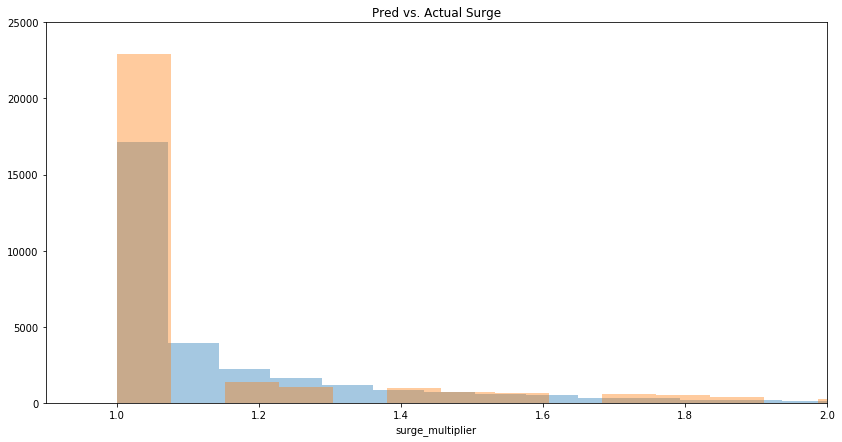

Blue = Predicted
Orange = Actual

Average surge prediction error: 0.10


In [136]:
plt.figure(figsize=(14,7))

ax = sns.distplot(df.pred_surge, kde = False)
sns.distplot(df.surge_multiplier, kde = False)

ax.set_xlim(0.9, 2)
ax.set_ylim(0,25000)
ax.set_title('Pred vs. Actual Surge')
plt.show()

print('Blue = Predicted')
print('Orange = Actual')

print()

df['pred_surge - actual_surge'] = abs(df['pred_surge'] - df['surge_multiplier'])
print('Average surge prediction error: ' + str(df['pred_surge - actual_surge'].mean())[:4])

## Chelsea heatmap
<br>
<font size = 4>Now that we have a model let's predict where we should be driving in Chelsea </font>

In [137]:
places = list(df.start_geo.value_counts().index)
places

['Chelsea Court', 'Allen Abby', 'Daisy Drive', 'Blair Bend']

In [138]:
surge_tables = []
for n in range(len(places)):
    days = []
    hours = []
    surge_ave = []
    place_df = df[df['start_geo'] == places[n]]
    for i in range(0,7):
        for j in range(0,24):
            days.append(i)
            hours.append(j)
            data = place_df[(place_df['days'] == i) & (place_df['hours'] == j)]
            surge_ave.append(data.pred_surge.mean())
            
    pivot1 = pd.DataFrame()
    pivot1['days'] = days
    pivot1['hour'] = hours
    pivot1['surge_ave'] = surge_ave
    
    x_piv = pivot1.pivot(index='hour', columns='days', values='surge_ave')
    surge_tables.append(x_piv)

Text(0.5,1,'Chelsea Court : Predicted Surge')

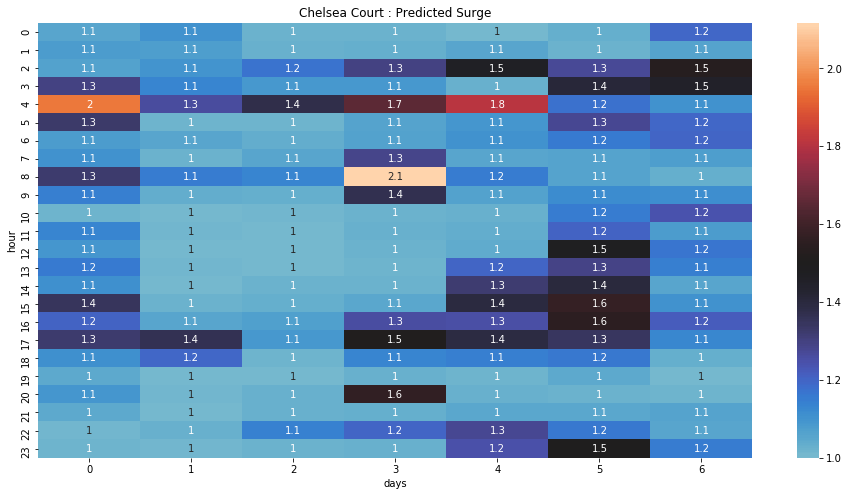

In [139]:
plt.figure(figsize=(16,8))
ax = sns.heatmap(surge_tables[0], vmin=1, annot = True, center = 1.5 )
ax.set_title(places[0]+' : Predicted Surge')

## Create a recommender function
<br>

<font size = 4>Use the pivot table for each area and compare to give the area with the highest predicted surge during a particular time. </font>

## Function to determine best area for driving by surge metric.

In [140]:
def best_area(day, hour):
    most = 0
    area = 0
    for i in range(0,4):
        x = surge_tables[i][day].iloc[hour]
        if x > most:
            most = x
            area = i
    return places[area], most

best_area(4,4)

('Allen Abby', 2.2384595249802763)

## Function to determine the best n hour work block

In [141]:
def optimal_work_day(day, work_hours):
    surge_value = 0
    solution = []
    for j in range(0, (24 - work_hours)):
        list_of_times = []
        local_surge_value = []
        for i in range(1,(work_hours + 1)):
            x, y = best_area(day, j + i)
            local_surge_value.append(y)
            z = [x, y, (j +i)]
            list_of_times.append(z)
        if sum(local_surge_value) > surge_value:
            surge_value = sum(local_surge_value)
            solution = list_of_times
    return solution

In [142]:
optimal_work_day(0, 8)

[['Daisy Drive', 1.1869990369837269, 2],
 ['Chelsea Court', 1.3002636202388804, 3],
 ['Allen Abby', 2.1237219916796244, 4],
 ['Blair Bend', 2.026105797843308, 5],
 ['Allen Abby', 1.508144735234843, 6],
 ['Blair Bend', 1.408080534968123, 7],
 ['Allen Abby', 1.5990931116392904, 8],
 ['Allen Abby', 1.377607281146773, 9]]